<a href="https://colab.research.google.com/github/ogunjosam/osogbo_purpleair_chaos/blob/main/osogbo_purpleair_chaos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chaotic and multifractal analysis of atmospheric variables at different temporal resolution in a tropical location

In this study, we will look at atmospheric variable (temperature, pressure, relative humidity) and pollutants (PM1, PM2.5, PM10) at different temporal resolution (2, 4, 6, 8, 10 minutes).  The analysis will be carried out on a monthly basis to see the seasonal variations while bypassing the data length restrictions. 

Tentatively, the following analysis will be carried out

1. Lyapunov exponent
2. Correlation dimension
3. Sample entropy
4. Multifractal analysis

Install and import packages here

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

!pip install nolds


import nolds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Plot the time series for the variables

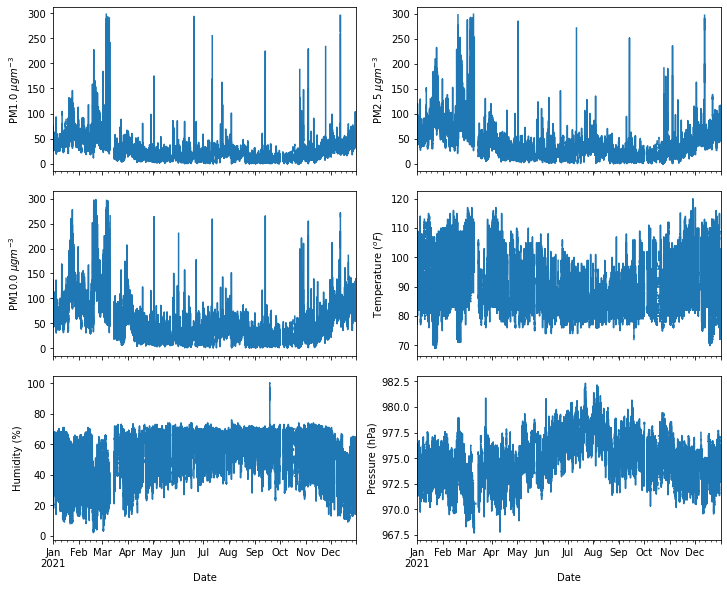

In [ ]:
fig,ax = plt.subplots(3,2,figsize=(10,8),sharex=True,sharey=False)
fig.subplots_adjust(hspace=0.0,wspace=0.0)
plt.tight_layout(h_pad=1,w_pad=3)
axf = ax.flatten()

url = 'https://github.com/ogunjosam/osogbo_purpleair_chaos/raw/main/osogbo_chaos_final.xlsx'
xx = pd.read_excel(url,index_col='Date')

lbl = ['PM1.0 $\mu g m^{-3}$','PM2.5 $\mu g m^{-3}$','PM10.0 $\mu g m^{-3}$','Temperature ($^o F$)', 'Humidity (%)', 'Pressure (hPa)' ]
for i,ii in enumerate(list(xx)):
  if ii.startswith('PM'):
    xx[xx[ii]>300] = np.nan
  xx[ii].plot(ax=axf[i])
  axf[i].set_ylabel(lbl[i])

plt.savefig('fig1.png', dpi = 300,bbox_inches="tight")

multifractal function

In [ ]:
def process_input(xsignal):
    '''
    Construct the profile for both forward and backward arrangement of data
    '''
    Fluct1 = np.cumsum(xsignal-xsignal.mean())
    FluctRev1 = np.flipud(Fluct1)
    
    return Fluct1,FluctRev1

def MFDFA(xsignal,m,scales,q):
    '''
    Parameters
    ----------
    xsignal -  first signal
    m - order of polynomial
    scales - 
    q
    
    Returns
    ----------
    Hq:           q-generalized Hurst exponent
    h:            Hölder exponent 
    Dh:           Multifractal spectrum 
    logFq:        q-generalized scaling function F(s,q) in log coordinates
    
    ---------------------------------------------------------
    '''
    
    x,x_r = process_input(xsignal)
    ss = np.linspace(np.log2(scales[0]),np.log2(scales[-1]),scales.shape[0]-1,endpoint=True)
    s = np.round(2**ss)
    znumb = np.argwhere(q==0)
    Fq = np.zeros((int(s.shape[0]),np.size(q)))

    for i in np.arange(s.shape[0]):
        Ns = np.floor(np.round(1/(s[i]/x.shape)))
        Var = np.zeros((int(Ns),np.size(q)))
        Varr = np.zeros((int(Ns),np.size(q)))
        for v in np.arange(Ns):
            SegNumb = np.arange(int(((v-1)*s[i])),int((v)*s[i]))
            Seg1 = x[SegNumb]
            Seg1_r = x_r[SegNumb]
            poly1 = np.polyfit(SegNumb,Seg1,m)
            poly1_r = np.polyfit(SegNumb,Seg1_r,m)
            fit1 = np.polyval(poly1,SegNumb)
            fit1_r = np.polyval(poly1_r,SegNumb)
            
            for nq in np.arange(q.shape[0]):
                Var[int(v),int(nq)] = (np.sum(((Seg1-fit1)**2)/s[i])**(q[nq]/4))
                Varr[int(v),int(nq)] = ((np.sum(((Seg1_r-fit1_r)**2))/s[i])**(q[nq]/4))
                
        for j in np.arange(q.shape[0]):
            Fq[i,j] = ((Var[:,j].sum(axis=0) + Varr[:,j].sum(axis=0))/(2*Ns))**(1/q[j])
        
        Fq[i,znumb] = (Fq[i,znumb-1] + Fq[i,znumb+1])/2
        logFq = np.log2(Fq)
        
    Hq = np.zeros(np.size(q))
    
    for k in np.arange(q.shape[0]):
        P = np.polyfit(np.log2(s),np.log2(Fq[:,k]),m)
        Hq[k] = P[0]
        
    tau = q*Hq - 1
    hh = np.diff(tau)/(q[1] - q[0])
    Dh = q[:-1]*hh - tau[:-1]
    h = hh - 1
    
    alpha0 = h[np.argmax(Dh)]
    alpha = np.max(h) - np.min(h)
    r = (np.max(h) - alpha0)/(alpha0 - np.min(h))
        
    return s,Hq,h, Dh, logFq,round(alpha0,2),round(alpha,2),round(r,2)

For the entire period

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-pa

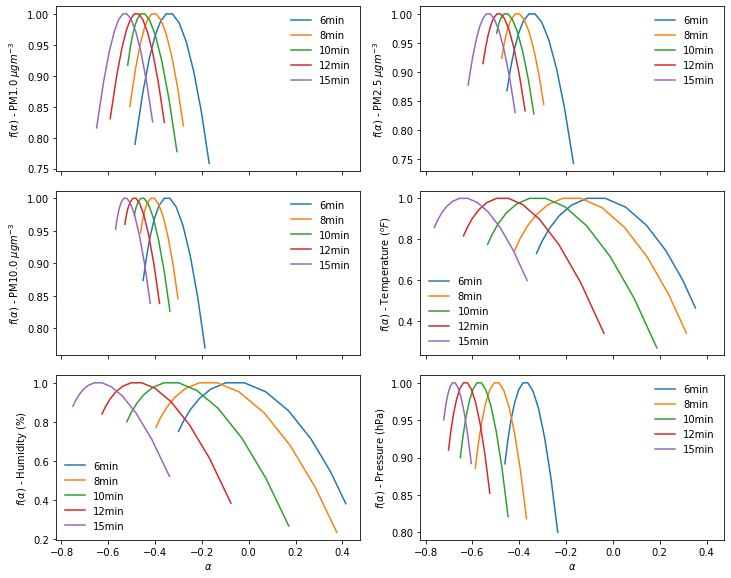

In [ ]:
fig,ax = plt.subplots(3,2,figsize=(10,8),sharex=True,sharey=False)
fig.subplots_adjust(hspace=0.0,wspace=0.0)
plt.tight_layout(h_pad=1,w_pad=3)
axf = ax.flatten()

qstep = 4
qs = np.arange(-3,3.1,2.0/qstep)
scstep = 4
scales = np.floor(2.0**np.arange(6,8,1.0/scstep)).astype('i4')

smpt = ['6min','8min','10min','12min','15min']

url = 'https://github.com/ogunjosam/osogbo_purpleair_chaos/raw/main/osogbo_chaos_final.xlsx'
xx = pd.read_excel(url,index_col='Date')
#xx['Month'] = xx.index.month

results = []
for i,ii in enumerate(list(xx)):
  if ii.startswith('PM'):
    xx[xx[ii]>300] = np.nan

  
  for j,jj in enumerate(smpt):
    xy = xx[ii].resample(jj).mean()
    s,Hq,h, Dh, logFq,a1,a2,a3 = MFDFA(xy.dropna().values,1,scales,qs)
    results.append([ii,jj,a1,a2,a3,xy.dropna().mean()])
    axf[i].plot(h,Dh,label=jj)
    axf[i].legend(frameon=False)
    axf[i].set_ylabel(r'$f(\alpha)$ - '+ lbl[i])
    

axf[4].set_xlabel(r'$\alpha$')
axf[5].set_xlabel(r'$\alpha$')
results = pd.DataFrame(results,columns=['Parameters','Temporal Resolution','alpha0','alpha','r','Mean'])

plt.savefig('fig4.png', dpi = 300,bbox_inches="tight")

Generalized Hurst exponent

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-pa

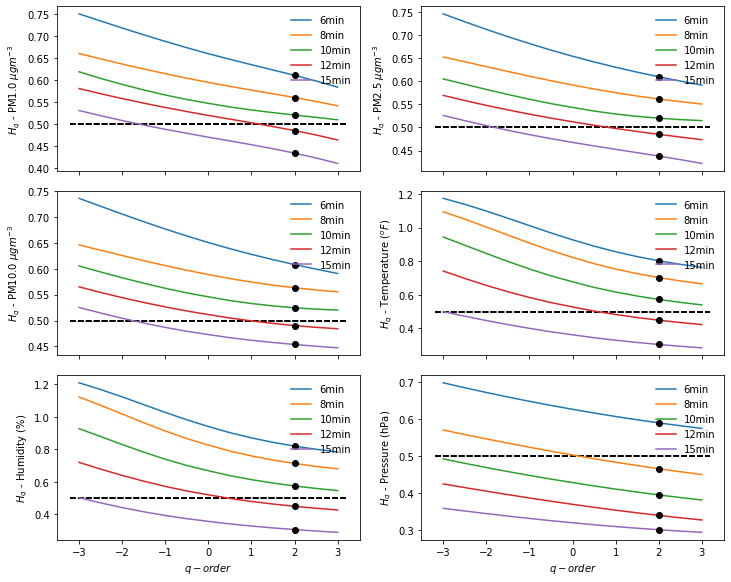

In [ ]:
fig,ax = plt.subplots(3,2,figsize=(10,8),sharex=True,sharey=False)
fig.subplots_adjust(hspace=0.0,wspace=0.0)
plt.tight_layout(h_pad=1,w_pad=3)
axf = ax.flatten()

qstep = 4
qs = np.arange(-3,3.1,2.0/qstep)
scstep = 4
scales = np.floor(2.0**np.arange(6,8,1.0/scstep)).astype('i4')

smpt = ['6min','8min','10min','12min','15min']

url = 'https://github.com/ogunjosam/osogbo_purpleair_chaos/raw/main/osogbo_chaos_final.xlsx'
xx = pd.read_excel(url,index_col='Date')
#xx['Month'] = xx.index.month

results = []
for i,ii in enumerate(list(xx)):
  if ii.startswith('PM'):
    xx[xx[ii]>300] = np.nan

  
  for j,jj in enumerate(smpt):
    xy = xx[ii].resample(jj).mean()
    s,Hq,h, Dh, logFq,a1,a2,a3 = MFDFA(xy.dropna().values,1,scales,qs)
    results.append([ii,jj,a1,a2,a3,xy.dropna().mean()])
    axf[i].plot(qs,Hq,label=jj)
    axf[i].plot(qs[10],Hq[10],'ko')
    axf[i].hlines(0.5,linestyles='dashed',colors='k',xmin=-3.2,xmax=3.2)
    axf[i].legend(frameon=False)
    axf[i].set_ylabel(r'$H_q$ - '+ lbl[i])
    

axf[4].set_xlabel(r'$q-order$')
axf[5].set_xlabel(r'$q-order$')
results = pd.DataFrame(results,columns=['Parameters','Temporal Resolution','alpha0','alpha','r','Mean'])

plt.savefig('fig3.png', dpi = 300,bbox_inches="tight")



Do the MFDFA for each variable over each months of the year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in double_scalars


"\nfig,ax = plt.subplots(3,2,figsize=(10,8),sharex=True,sharey=False)\nfig.subplots_adjust(hspace=0.0,wspace=0.0)\nplt.tight_layout(h_pad=1,w_pad=3)\naxf = ax.flatten()\n\nfor p,parameter in enumerate(results['Parameters'].unique()):\n  xc = results[results['Parameters']==parameter]\n  sns.lineplot(x='Month',y='r',data=xc,hue='Temporal Resolution',ax=axf[p],markers=True,style='Temporal Resolution')\n  #xc['Mean'].plot(ax=axf[p],secondary_y=True)\n  #sns.lineplot(x='Month',y='Mean',data=xc,ax=axf[p])\n  axf[p].set_ylabel(parameter)\n  axf[p].legend(frameon=False)\n"

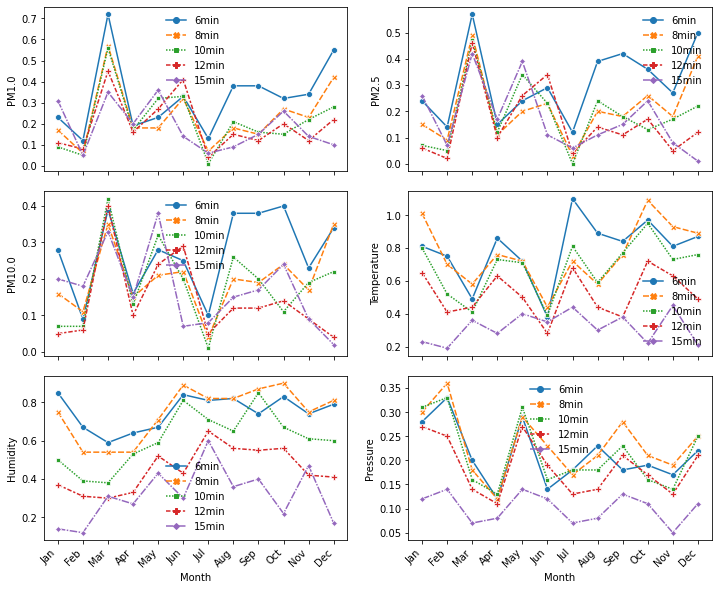

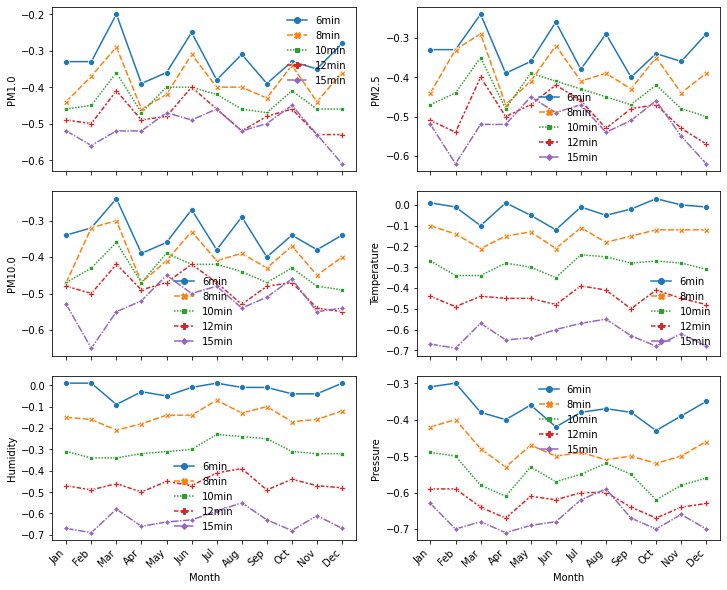

In [ ]:
qstep = 4
qs = np.arange(-3,3.1,2.0/qstep)
scstep = 4
scales = np.floor(2.0**np.arange(6,8,1.0/scstep)).astype('i4')

smpt = ['6min','8min','10min','12min','15min']
lbls = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

url = 'https://github.com/ogunjosam/osogbo_purpleair_chaos/raw/main/osogbo_chaos_final.xlsx'
xx = pd.read_excel(url,index_col='Date')
#xx['Month'] = xx.index.month

results = []
for i,ii in enumerate(list(xx)):
  if ii.startswith('PM'):
    xx[xx[ii]>300] = np.nan

  
  for j,jj in enumerate(smpt):
    xy = xx[ii].resample(jj).mean()

    for k in np.arange(1,13):
      xk = xy[xy.index.month==k]
      s,Hq,h, Dh, logFq,a1,a2,a3 = MFDFA(xk.dropna().values,1,scales,qs)
      results.append([ii,jj,a1,a2,a3,k,xk.dropna().mean()])
    


results = pd.DataFrame(results,columns=['Parameters','Temporal Resolution','alpha0','alpha','r','Month','Mean'])

fig,ax = plt.subplots(3,2,figsize=(10,8),sharex=True,sharey=False)
fig.subplots_adjust(hspace=0.0,wspace=0.0)
plt.tight_layout(h_pad=1,w_pad=3)
axf = ax.flatten()

for p,parameter in enumerate(results['Parameters'].unique()):
  xc = results[results['Parameters']==parameter]
  sns.lineplot(x='Month',y='alpha',data=xc,hue='Temporal Resolution',ax=axf[p],markers=True,style='Temporal Resolution')
  #xc['Mean'].plot(ax=axf[p],secondary_y=True)
  #sns.lineplot(x='Month',y='Mean',data=xc,ax=axf[p])
  axf[p].set_ylabel(parameter)
  axf[p].legend(frameon=False)
  axf[p].set_xticks([1, 2, 3,4,5,6,7,8,9,10,11,12])
  axf[p].set_xticklabels(lbls, rotation=45, ha='right')

plt.savefig('fig5.png', dpi = 300,bbox_inches="tight")

#sns.boxplot(x='Month',y='alpha',data=results)
fig,ax = plt.subplots(3,2,figsize=(10,8),sharex=True,sharey=False)
fig.subplots_adjust(hspace=0.0,wspace=0.0)
plt.tight_layout(h_pad=1,w_pad=3)
axf = ax.flatten()

for p,parameter in enumerate(results['Parameters'].unique()):
  xc = results[results['Parameters']==parameter]
  sns.lineplot(x='Month',y='alpha0',data=xc,hue='Temporal Resolution',ax=axf[p],markers=True,style='Temporal Resolution')
  #xc['Mean'].plot(ax=axf[p],secondary_y=True)
  #sns.lineplot(x='Month',y='Mean',data=xc,ax=axf[p])
  axf[p].set_ylabel(parameter)
  axf[p].legend(frameon=False)
  axf[p].set_xticks([1, 2, 3,4,5,6,7,8,9,10,11,12])
  axf[p].set_xticklabels(lbls, rotation=45, ha='right')

plt.savefig('fig6.png', dpi = 300,bbox_inches="tight")
'''
fig,ax = plt.subplots(3,2,figsize=(10,8),sharex=True,sharey=False)
fig.subplots_adjust(hspace=0.0,wspace=0.0)
plt.tight_layout(h_pad=1,w_pad=3)
axf = ax.flatten()

for p,parameter in enumerate(results['Parameters'].unique()):
  xc = results[results['Parameters']==parameter]
  sns.lineplot(x='Month',y='r',data=xc,hue='Temporal Resolution',ax=axf[p],markers=True,style='Temporal Resolution')
  #xc['Mean'].plot(ax=axf[p],secondary_y=True)
  #sns.lineplot(x='Month',y='Mean',data=xc,ax=axf[p])
  axf[p].set_ylabel(parameter)
  axf[p].legend(frameon=False)
'''

Check if there is a linear relationship

Mean 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in double_scalars


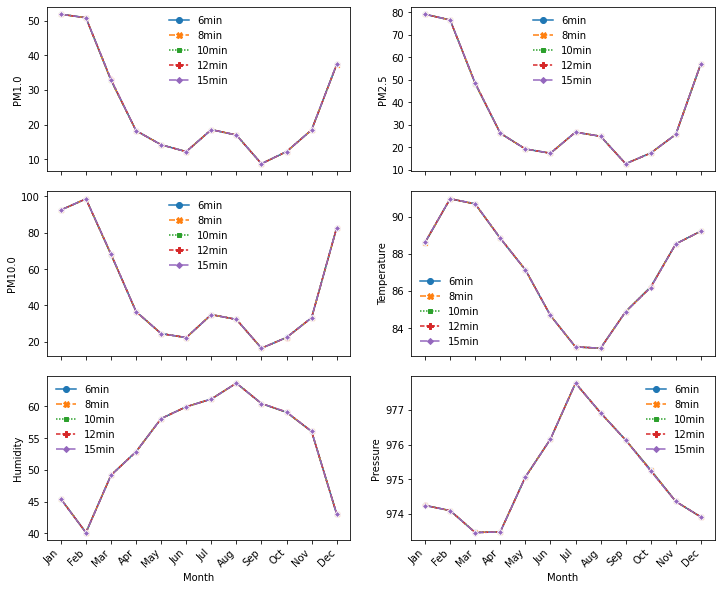

In [ ]:
qstep = 4
qs = np.arange(-3,3.1,2.0/qstep)
scstep = 4
scales = np.floor(2.0**np.arange(6,8,1.0/scstep)).astype('i4')

smpt = ['6min','8min','10min','12min','15min']

url = 'https://github.com/ogunjosam/osogbo_purpleair_chaos/raw/main/osogbo_chaos_final.xlsx'
xx = pd.read_excel(url,index_col='Date')
#xx['Month'] = xx.index.month

results = []
for i,ii in enumerate(list(xx)):
  if ii.startswith('PM'):
    xx[xx[ii]>300] = np.nan

  
  for j,jj in enumerate(smpt):
    xy = xx[ii].resample(jj).mean()

    for k in np.arange(1,13):
      xk = xy[xy.index.month==k]
      s,Hq,h, Dh, logFq,a1,a2,a3 = MFDFA(xk.dropna().values,1,scales,qs)
      results.append([ii,jj,a1,a2,a3,k,xk.dropna().mean()])
    


results = pd.DataFrame(results,columns=['Parameters','Temporal Resolution','alpha0','alpha','r','Month','Mean'])

fig,ax = plt.subplots(3,2,figsize=(10,8),sharex=True,sharey=False)
fig.subplots_adjust(hspace=0.0,wspace=0.0)
plt.tight_layout(h_pad=1,w_pad=3)
axf = ax.flatten()

lbls = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for p,parameter in enumerate(results['Parameters'].unique()):
  xc = results[results['Parameters']==parameter]
  sns.lineplot(x='Month',y='Mean',data=xc,hue='Temporal Resolution',ax=axf[p],markers=True,style='Temporal Resolution')
  #xc['Mean'].plot(ax=axf[p],secondary_y=True)
  #sns.lineplot(x='Month',y='Mean',data=xc,ax=axf[p])
  axf[p].set_ylabel(parameter)
  axf[p].legend(frameon=False)
  axf[p].set_xticks([1, 2, 3,4,5,6,7,8,9,10,11,12])
  axf[p].set_xticklabels(lbls, rotation=45, ha='right')

#sns.boxplot(x='Month',y='alpha',data=results)
plt.savefig('fig2.png', dpi = 300,bbox_inches="tight")

In [ ]:
def process_input2(xsignal,ysignal):
    '''
    Construct the profile for both forward and backward arrangement of data
    '''
    Fluct1 = np.cumsum(xsignal-xsignal.mean())
    Fluct2 = np.cumsum(ysignal-ysignal.mean())
    
    FluctRev1 = np.flipud(Fluct1)
    FluctRev2 = np.flipud(Fluct2)
    
    return Fluct1, Fluct2,FluctRev1,FluctRev2
    
def MFXDA(xsignal,ysignal,m,scales,q):
    '''
    Parameters
    ----------
    xsignal -  first signal
    ysignal - second signal
    m - order of polynomial
    scales - 
    q
    
    Returns
    ----------
    Hq:           q-generalized Hurst exponent
    h:            Hölder exponent 
    Dh:           Multifractal spectrum 
    logFq:        q-generalized scaling function F(s,q) in log coordinates
    
    ---------------------------------------------------------
    '''
    
    x,y,x_r,y_r = process_input2(xsignal,ysignal)
    ss = np.linspace(np.log2(scales[0]),np.log2(scales[-1]),scales.shape[0]-1,endpoint=True)
    s = np.round(2**ss)
    znumb = np.argwhere(q==0)
    Fq = np.zeros((int(s.shape[0]),np.size(q)))
    
    for i in np.arange(s.shape[0]):
        Ns = np.floor(np.round(1/(s[i]/x.shape)))
        Var = np.zeros((int(Ns),np.size(q)))
        Varr = np.zeros((int(Ns),np.size(q)))
        for v in np.arange(Ns):
            #SegNumb = np.arange(int(((v-1)*s[i]) + 1),int((v)*s[i])).transpose()
            SegNumb = np.arange(int(((v-1)*s[i])),int((v)*s[i]))
            Seg1 = x[SegNumb]
            Seg1_r = x_r[SegNumb]
            poly1 = np.polyfit(SegNumb,Seg1,m)
            poly1_r = np.polyfit(SegNumb,Seg1_r,m)
            fit1 = np.polyval(poly1,SegNumb)
            fit1_r = np.polyval(poly1_r,SegNumb)
            
            Seg2 = y[SegNumb]
            Seg2_r = y_r[SegNumb]
            poly2 = np.polyfit(SegNumb,Seg2,m)
            poly2_r = np.polyfit(SegNumb,Seg2_r,m)
            fit2 = np.polyval(poly2,SegNumb)
            fit2_r = np.polyval(poly2_r,SegNumb)
           
            #print(mn)
            for nq in np.arange(q.shape[0]):
                Var[int(v),int(nq)] = ((np.sum(((Seg1-fit1)**2)*((Seg2-fit2)**2))/s[i])**(q[nq]/4))
                Varr[int(v),int(nq)] = ((np.sum(((Seg1_r-fit1_r)**2)*((Seg2_r-fit2_r)**2))/s[i])**(q[nq]/4))
            
        for j in np.arange(q.shape[0]):
            Fq[i,j] = ((Var[:,j].sum(axis=0) + Varr[:,j].sum(axis=0))/(2*Ns))**(1/q[j])
        
        Fq[i,znumb] = (Fq[i,znumb-1] + Fq[i,znumb+1])/2
        
        logFq = np.log2(Fq)
        
    Hq = np.zeros(np.size(q))  

    for k in np.arange(q.shape[0]):
        P = np.polyfit(np.log2(s),np.log2(Fq[:,k]),m)
        Hq[k] = P[0]
    
    tau = q*Hq - 1
    hh = np.diff(tau)/(q[1] - q[0])
    Dh = q[:-1]*hh - tau[:-1]
    h = hh - 1
    
    alpha0 = h[np.argmax(Dh)]
    alpha = np.max(h) - np.min(h)
    #r = (np.max(h) - alpha0)/(alpha0 - np.min(h))
    r_l = alpha0 - h[0]
    r_r = h[-1] - alpha0
    
    r = (r_l - r_r)/(r_l + r_r)
        
    return s,Hq,h, Dh, logFq,round(alpha0,2),round(alpha,2),round(r,2)


In [ ]:
import warnings
warnings.filterwarnings("ignore")

fig,ax = plt.subplots(6,6,figsize=(10,8),sharex=True,sharey=True)
fig.subplots_adjust(hspace=0.0,wspace=0.0)
plt.tight_layout(h_pad=1,w_pad=3)
axf = ax.flatten()

qstep = 4
qs = np.arange(-3,3.1,2.0/qstep)
scstep = 4
scales = np.floor(2.0**np.arange(6,8,1.0/scstep)).astype('i4')

smpt = ['6min','8min','10min','12min','15min']

url = 'https://github.com/ogunjosam/osogbo_purpleair_chaos/raw/main/osogbo_chaos_final.xlsx'
xx = pd.read_excel(url,index_col='Date')
xx = xx.dropna(how='any')
xx2 = xx
#xx['Month'] = xx.index.month

results = []
kl = 0
for i,ii in enumerate(list(xx)):
  if ii.startswith('PM'):
    xx[ii][xx[ii]>300] = np.nan
  for ik,ii2 in enumerate(list(xx2)):
    if ii2.startswith('PM'):
      xx2[ii2][xx2[ii2]>300] = np.nan
      print([i,ik])

  
    for j,jj in enumerate(smpt):
      xy = xx[ii].resample(jj).mean()
      xy2 = xx[ii2].resample(jj).mean()
      s,Hq,h, Dh, logFq,a1,a2,a3 = MFXDA(xy.dropna().values,xy2.dropna().values,1,scales,qs)
      results.append([ii,ii2,jj,a1,a2,a3])
      axf[kl].plot(h,Dh,label=jj)
      #axf[kl].legend(frameon=False)
      #axf[kl].set_ylabel(r'$f(\alpha)$ - '+ lbl[i])
    kl+=1
    

#axf[4].set_xlabel(r'$\alpha$')
#axf[5].set_xlabel(r'$\alpha$')
results = pd.DataFrame(results,columns=['Parameter1','Parameter2','Temporal Resolution','alpha0','alpha','r'])

#plt.savefig('fig4.png', dpi = 300,bbox_inches="tight")